# 0. Problem statement

As a **quantitative analyst**, I am interested in determining whether the following trading strategy using the RSI oscillator on S&P500 stocks can yield positive risk-adjusted returns for our portfolio:
- Buy the stock when the RSI oscillator hits 30. 
- Sell the stock either when the RSI oscillator hits 70 or by the end of the month (whichever comes first). 

# I. Approach

- $H_0$: The risk adjusted return for our portfolio is less than or equal to 0%.
- $H_a$: The risk adjusted return for our portfolio is greater than 0%.

We have 500 stocks to choose from and our dataset of S&P500 stocks has each company's GICS sector as well. So, we can use stratified random sampling to select a "mini-S&P 500 portfolio" on each run and apply our trading strategy to evaluate our monthly returns. From a quick google search, we see that most of the companies that are part of the S&P500 index today have been publicly listed for at least 3 years (which can be our time period for back-testing). However, there are some exceptions (found from an initial run of downloading the data). This is elabored upon later in this notebook, but the bottom-line is that we will be removing those tickers from our analysis.

Here are some rules we can set for ourselves:
- Every time one of our 30 stocks' RSI value hits 30, we will invest $\$1000$. 
- Since we can't assume we have an infinite amount of cash on us, we will start our 3 year period with $\$30000$. 
- We are expected to liquidate all our positions by EOM, we will know what our total cash balance is at the end.
- If the cash balance at the start of the month is less than $\$30,000$, then we will not be allowed to invest in all 30 companies if we wanted to (i.e. we cannot purchase stock on margin). 
- If the cash balance at the start of the month is greater than $\$30000$, then we will be allowed to invest a greater dollar amount per company; so, if our cash balance started at $\$33000$, then we will be allowed to invest $\$33,000/30 = \$1100$ per company. 

# II. Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pandas_datareader.data as reader
import datetime as dt
from datetime import timedelta
from typing import Iterable, Union
import itertools
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from plotly import express as px

In [2]:
import logging

# III. S&P500 data exploration

In [3]:
sp500_df = pd.read_csv("data/sp_500_stocks.csv")

In [4]:
sp500_df.head()

,Symbol,Description,Category2,Category3,GICS Sector,Market cap,Dividend yield,Price to TTM earnings,Price to TTM sales,Price to book value
0,AAPL,Apple Inc,Common stocks,Large cap,Information Technology,"$2,865,693,839,600",0.50%,29.04,7.57,40.60
1,MSFT,Microsoft Corp,Common stocks,Large cap,Information Technology,"$2,329,276,399,180",0.76%,33.22,12.60,14.78
2,GOOG,Alphabet Inc Class C,Common stocks,Large cap,Communication Services,"$1,916,810,491,712",0.00%,11.89,7.44,3.59
3,GOOGL,Alphabet Inc Class A,Common stocks,Large cap,Communication Services,"$1,916,810,491,712",0.00%,11.27,7.44,3.41
4,AMZN,Amazon.Com Inc.,Common stocks,Large cap,Consumer Discretionary,"$1,719,797,425,362",0.00%,51.65,3.66,12.46


In [5]:
# Ensuring that our tickers are unique
sp500_df["Symbol"].is_unique

True

In [6]:
def tickers_to_remove(df: pd.DataFrame, ticker_list: Iterable) -> pd.DataFrame:
    mask = True
    
    for ticker in ticker_list:
        mask &= (df["Symbol"] != ticker)
    
    return df.loc[mask].reset_index(drop=True)

In [7]:
def replace_ticker_names(df: pd.DataFrame, old_to_new_ticker_mapping: dict) -> pd.DataFrame:
    for old, new in old_to_new_ticker_mapping.items():
        df.loc[df["Symbol"] == old, "Symbol"] = new
    
    return sp500_df

The tickers below are of stocks that have IPO'd much later into our 3 year window and would limit the time we will be back-testing our data for.

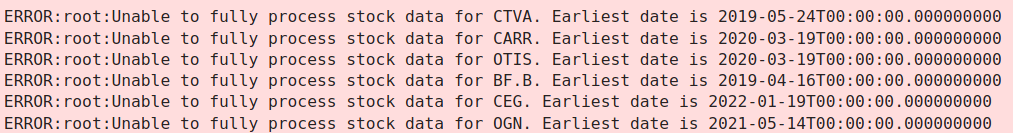

Removing the tickers in this list as well as "GOOGL" and "UAA". Removing "Alphabet Inc Class A" and "Under Armour Class A" shares, which are both just common shares with voting rights. As far as trends are concerned in the stock price movement for that company, it will be the same for both class A and class C shares. So, removing the former to have just one ticker per company in this dataset. 

In [8]:
sp500_df = tickers_to_remove(sp500_df, ["GOOGL", "UAA", "CTVA", "CARR", "OTIS", "BF.B", "CEG", "OGN", "AMCR"])

In [9]:
old_to_new_ticker_mapping = {
    "BRK.B": "BRK-B"
}

sp500_df = replace_ticker_names(sp500_df, old_to_new_ticker_mapping)

In [10]:
sector_mapping = {
    "Information Technology": "IT",
    "Information technology": "IT", 
    "Industrials": "ID",
    "Financials": "F",
    "Health Care": "HC",
    "Consumer Discretionary": "CD",
    "Consumer Staples": "CS",
    "Utilities": "U",
    "Real Estate": "RE",
    "Materials": "M",
    "Communication Services": "CM",
    "Energy": "E"
}

sp500_df["sector"] = sp500_df["GICS Sector"].replace(sector_mapping)

In [11]:
sp500_df["sector"].value_counts()

IT    75
ID    70
F     67
HC    64
CD    59
CS    31
RE    29
U     28
CM    26
M     26
E     21
Name: sector, dtype: int64

# IV. Calculating $\beta$ and RSI:

We can use the following formula to compute the $\beta$ for each stock over our back-testing period:
$$\beta_i = \frac{Cov(R_i, R_m)}{\sigma_m^2}$$
where:
- $R_i$ is the return of asset $i$.
- $R_m$ is the return on our chosen market index: S&P 500.
- $\sigma_m$ is the standard deviation of returns on the chosen market index.

In [12]:
def calculate_daily_returns(series_of_prices: pd.Series) -> pd.Series:
    return np.log(series_of_prices/series_of_prices.shift())

In [13]:
def calculate_beta(asset_returns: pd.Series, index_returns: pd.Series, index_returns_var: float) -> pd.Series:
    cov_matrix = np.cov(asset_returns, sp500_returns)
    return cov_matrix[0,1]/index_returns_var

We can calculate RSI on a standard 14-d window using the following formula:
$$RSI=100-\frac{100}{1+RS}$$
where:
- RS is the relative strength indicator and is given by $RS = \sum_{d=1}^{14} \frac{total~returns~up}{total~returns~down}$

In [14]:
def calculate_rsi(df: pd.DataFrame) -> pd.DataFrame:
    mask = df["daily_return"] >= 0
    
    df["is_up"] = (df["daily_return"] >= 0).replace({True: 1, False: 0})
    df["is_down"] = (df["daily_return"] < 0).replace({True: 1, False: 0})
    df["up_return"] = df["is_up"]*df["daily_return"]
    df["down_return"] = df["is_down"]*abs(df["daily_return"])

    df["RSI"] = 100 - 100/(1+df["up_return"].rolling(14).sum()/df["down_return"].rolling(14).sum())
    
    df = df.drop(columns=["is_up", "is_down", "up_return", "down_return"])
    
    return df

# V. Loading, pre-processing, and locally storing our datasets 

It would be a good idea for us to store our datasets locally for the following reasons:
1. We don't have to run the API calls every time we wish to load the same data
2. These datasets can be useful for other analyses (outside this notebook) as well.

**So, if you have not run the code below, please do.**

In [15]:
common_path = "data/sp500/"
earliest_data_fetch_date = dt.datetime(2019, 3, 1).date()
start_date = dt.datetime(2019, 4, 15).date()
end_date = dt.datetime(2022, 3, 30).date()
index_ticker = ("^GSPC")    # S&P 500

In [16]:
def get_stock_data(ticker: str, start_date: dt, end_date: dt) -> pd.DataFrame:
    return reader.get_data_yahoo(ticker, earliest_data_fetch_date, end_date)

In [17]:
def write_df_to_local_directory(path: str, df: pd.DataFrame) -> None:
    df.to_parquet(path)

In [18]:
def preprocess_input_df(df: pd.DataFrame, earliest_start_date: dt) -> pd.DataFrame:   
    df = df.reset_index()
    df = df.rename(columns={
        "Date": "date", 
        "High": "high", 
        "Low": "low", 
        "Open": "open", 
        "Close": "close", 
        "Adj Close": "closing_price"
    })
    df = df.drop_duplicates(subset=["date"])
    
    df["daily_return"] = calculate_daily_returns(df["closing_price"])
    
    df = calculate_rsi(df)
    
    return df.loc[df["date"] > pd.Timestamp(start_date)]

In [19]:
def get_10y_treasury_yield_data(index_df: pd.DataFrame, start_date: dt) -> pd.DataFrame:
    path = "data/10-year-treasury-yield.csv"
    
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df["date"])
    df = df.rename(columns={" value": "yield"}).set_index("date")
    df = df.reindex(index_df.set_index("date").index)
    
    return df.fillna(method="ffill")

In [20]:
def calculate_expected_returns(
    index_returns: pd.Series, ten_yr_yield: pd.Series, stock_beta_df: pd.DataFrame, ticker: str
) -> pd.DataFrame:
    capm_df = pd.DataFrame()
    ticker_beta = stock_beta_df.set_index("ticker").loc[ticker]["beta"]
    
    capm_df["rf"] = ten_yr_yield["yield"].reset_index(drop=True)/365
    capm_df["rm"] = sp500_returns.reset_index(drop=True)
    capm_df["er"] = capm_df["rf"] + ticker_beta*(capm_df["rm"] - capm_df["rf"])
    
    return capm_df

In [21]:
# Read and store index data
sp500 = get_stock_data(index_ticker, start_date, end_date)
sp500 = preprocess_input_df(sp500, earliest_data_fetch_date)
path = common_path + "sp500.parquet"
write_df_to_local_directory(path, sp500)

In [22]:
sp500_returns = sp500["daily_return"]
sp500_returns_variance = np.var(sp500_returns)

In [23]:
ten_yr_yield = get_10y_treasury_yield_data(sp500, start_date)

In [24]:
# stock_to_beta = {"ticker": [], "beta": []}

# for ticker in sp500_df["Symbol"]:
#     try:
#         df = get_stock_data(ticker, earliest_data_fetch_date, end_date)
#         df = preprocess_input_df(df, earliest_data_fetch_date)
#         stock_to_beta["beta"] += [calculate_beta(df["daily_return"], sp500_returns, sp500_returns_variance)]
#         stock_to_beta["ticker"] += [ticker]
#         path_ticker = common_path + f"{ticker}.parquet"
#         if all(~df["RSI"].isnull()):
#             write_df_to_local_directory(path_ticker, df)
#         else:
#             logging.warning(f"Stock data for {ticker} had null RSI values. So, we can't use this for analysis.")
#     except:
#         earliest_date = df["date"].values[0]
#         logging.error(f"Unable to fully process stock data for {ticker}. Earliest date is {earliest_date}")

# stock_to_beta = pd.DataFrame(stock_to_beta)
# path_beta = common_path + "stock_to_beta.parquet"
# write_df_to_local_directory(path_beta, stock_to_beta)

# VI. Choosing our sample on each iteration

In [25]:
sp500_df["sector"].value_counts()/len(sp500_df)*30

IT    4.536290
ID    4.233871
F     4.052419
HC    3.870968
CD    3.568548
CS    1.875000
RE    1.754032
U     1.693548
CM    1.572581
M     1.572581
E     1.270161
Name: sector, dtype: float64

Clearly, we can't get an even number of stocks per category, so let us use the normalised values above to determine a fixed number of companies to pick per category:

In [26]:
num_stocks_per_sector = {
    "IT": 4,
    "ID": 4,
    "F": 4,
    "HC": 4,
    "CD": 3,
    "CS": 2,
    "RE": 2,
    "U": 2,
    "M": 2,
    "CM": 2,
    "E": 1
}

In [27]:
tickers_per_sector = {}

for sector in num_stocks_per_sector.keys():
    mask = sp500_df["sector"] == sector
    tickers_per_sector[sector] = np.array(sorted(sp500_df.loc[mask]["Symbol"]))

In [28]:
def select_sample_for_backtesting(num_stocks_per_sector: dict, tickers_per_sector: dict) -> Iterable:
    sample_tickers = []
    
    for sector in num_stocks_per_sector.keys():
        tickers_in_sector = tickers_per_sector[sector]
        num_stocks = num_stocks_per_sector[sector]
        
        random_indices = np.random.randint(0, len(tickers_in_sector), num_stocks, dtype=int)
        
        sample_tickers += list(tickers_in_sector[random_indices])
    
    return sample_tickers

# VII. Iterate through our trading strategy

In [29]:
stock_sample = select_sample_for_backtesting(num_stocks_per_sector, tickers_per_sector)

In [30]:
stock_to_beta_df = pd.read_parquet(common_path + "stock_to_beta.parquet")

In [31]:
def create_compiled_df(
    df_with_date: pd.DataFrame, stock_sample: Iterable, common_path: str) -> pd.DataFrame:
    
    df = pd.DataFrame(sp500["date"]).reset_index(drop=True)
    
    for ticker in stock_sample:
        path = common_path + f"{ticker}.parquet"
        ticker_df = pd.read_parquet(path, columns=["closing_price", "RSI", "daily_return"]).reset_index(drop=True)
        df[f"closing_price_{ticker}"] = ticker_df["closing_price"]
        df[f"RSI_{ticker}"] = ticker_df["RSI"]
        df[f"daily_return_{ticker}"] = ticker_df["daily_return"]
    
    df = df.reset_index(drop=True)
    
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    
    eom_indices = df.reset_index().groupby(["month", "year"]).nth(-1)["index"]
    df["is_eom"] = df.index.isin(eom_indices)

    return df

In [32]:
def add_expected_returns(compiled_df: pd.DataFrame, ten_yr_yield: pd.Series, stock_to_beta_df: pd.DataFrame) -> pd.DataFrame:
    for ticker in stock_sample:
        capm_df = calculate_expected_returns(sp500_returns, ten_yr_yield, stock_to_beta_df, ticker)
        compiled_df[f"expected_daily_return_{ticker}"] = capm_df["er"]

    return compiled_df

In [33]:
def create_is_buy_df(df_with_date: pd.DataFrame, compiled_df: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame(sp500["date"]).reset_index(drop=True)
    
    for ticker in stock_sample:
        path = common_path + f"{ticker}.parquet"
        rsi_col = compiled_df[f"RSI_{ticker}"]
        mask = (rsi_col <= 30)
        mask &= (rsi_col.shift() > 30)
        df[f"is_buy_{ticker}"] = mask
    
    return df.reset_index(drop=True)

In [34]:
def create_is_sell_df(df_with_date: pd.DataFrame, compiled_df: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame(df_with_date["date"]).reset_index(drop=True)
    
    for ticker in stock_sample:
        path = common_path + f"{ticker}.parquet"
        rsi_col = compiled_df[f"RSI_{ticker}"]
        mask = (rsi_col >= 70)
        mask &= (rsi_col.shift() < 70)
        df[f"is_sell_{ticker}"] = mask
    
    return df.reset_index(drop=True)

In [35]:
def get_closing_price(compiled_df: pd.DataFrame, tr_date: dt, ticker: str) -> float:
    df = compiled_df.set_index("date")
    return df.loc[tr_date][f"closing_price_{ticker}"]

In [36]:
def get_RSI(compiled_df: pd.DataFrame, tr_date: dt, ticker: str) -> float:
    df = compiled_df.set_index("date")
    return df.loc[tr_date][f"RSI_{ticker}"]

In [37]:
def update_transaction_with_buy(
    transactions_df: pd.DataFrame, tr_date: dt, price: float, ticker: str, num_shares: float, cash_balance: float, investment_amount: float
) -> pd.DataFrame:
    
    action = 1
    index = len(transactions_df)
    transactions_df.loc[index, :] = [tr_date, ticker, action, price, num_shares, cash_balance]
    
    return transactions_df

In [38]:
def update_transaction_with_sell(
    transactions_df: pd.DataFrame, tr_date: dt, price: float, ticker: str, num_shares: float, cash_balance: float
) -> pd.DataFrame:
    
    action = -1
    index = len(transactions_df)
    transactions_df.loc[index, :] = [tr_date, ticker, action, price, num_shares, cash_balance]
    
    return transactions_df

In [39]:
def order_tickers_to_buy_by_rsi(tickers_to_buy: set, tr_date) -> set:
    ticker_to_RSI = {"ticker": [], "RSI": []}
    for ticker in tickers_to_buy:
        ticker_to_RSI["ticker"] += [ticker]
        ticker_to_RSI["RSI"] += [get_RSI(compiled_df, tr_date, ticker)]

    ticker_to_RSI = pd.DataFrame(ticker_to_RSI).sort_values(by="RSI", ascending=False)

    return list(ticker_to_RSI["ticker"])

In [40]:
def implement_trading_strategy(
    starting_cash: int, stock_sample: Iterable, compiled_df: pd.DataFrame, is_buy_df: pd.DataFrame, is_sell_df: pd.DataFrame
) -> Union[pd.DataFrame, float]:
    
    owned_stocks = []
    start_date = is_buy_df["date"][0]
    
    transactions_df = pd.DataFrame(
        {
            "date": start_date, 
            "stock": None, 
            "action": 0, 
            "price": 0, 
            "num_shares": 0,
            "cash_balance": starting_cash
        },
        index=[0]
    )
    
    bom_balance = starting_cash
    cash_balance = starting_cash
    monthly_gains = 0
    is_sufficient_balance = True
    ticker_to_num_shares_monthly = dict()
    ticker_to_purchase_date = dict()

    for row in range(len(is_buy_df)):
        is_buy = is_buy_df.iloc[row]
        tr_date = is_buy["date"]
        is_eom = compiled_df.set_index("date").loc[tr_date]["is_eom"]
        investment_amount = np.round(bom_balance/30, 2)
        
        if not is_eom:
            tickers_to_buy = set(s[7:] for s in is_buy[is_buy == True].index)
            tickers_to_buy = tickers_to_buy.difference(owned_stocks)
            tickers_to_buy = order_tickers_to_buy_by_rsi(tickers_to_buy, tr_date)

            is_sell = is_sell_df.iloc[row]
            tickers_to_sell = set(s[8:] for s in is_sell[is_sell == True].index)
            tickers_to_sell = list(tickers_to_sell.intersection(owned_stocks))
        else:
            tickers_to_buy = []
            tickers_to_sell = owned_stocks.copy()
                
        sell_index = 0
        while (len(tickers_to_sell) > 0) and (sell_index < len(tickers_to_sell)):
            ticker = tickers_to_sell[sell_index]
            days_held = (tr_date - ticker_to_purchase_date[ticker]).days
            if (days_held >= 45) or (tr_date.date() == end_date):
                price = get_closing_price(compiled_df, tr_date, ticker)
                num_shares = ticker_to_num_shares_monthly[ticker]
                cash_balance += num_shares*price
                transactions_df = update_transaction_with_sell(transactions_df, tr_date, price, ticker, num_shares, cash_balance)
                ticker_to_num_shares_monthly[ticker] = 0
                owned_stocks.remove(ticker)
            sell_index += 1
        
        if cash_balance > investment_amount:
            is_sufficient_balance = True

        buy_index = 0
        while (len(tickers_to_buy) > 0) and (is_sufficient_balance) and buy_index < len(tickers_to_buy):
            ticker = tickers_to_buy[buy_index]
            price = get_closing_price(compiled_df, tr_date, ticker)
            if cash_balance < investment_amount:
                is_sufficient_balance = False
            else:
                cash_balance -= investment_amount
                price = get_closing_price(compiled_df, tr_date, ticker)
                num_shares = np.round(investment_amount/price, 2)
                transactions_df = update_transaction_with_buy(transactions_df, tr_date, price, ticker, num_shares, cash_balance, investment_amount)
                ticker_to_num_shares_monthly[ticker] = num_shares
                ticker_to_purchase_date[ticker] = tr_date
                owned_stocks += [ticker]
                buy_index += 1
        
        if is_eom:
            bom_balance = transactions_df.iloc[len(transactions_df)-1]["cash_balance"]

            if bom_balance <= 0:
                break
        
    return transactions_df

In [41]:
compiled_df = create_compiled_df(sp500, stock_sample, common_path)
is_buy_df = create_is_buy_df(sp500, compiled_df)
is_sell_df = create_is_sell_df(sp500, compiled_df)

In [42]:
transactions_df = implement_trading_strategy(30000, stock_sample, compiled_df, is_buy_df, is_sell_df)

# VIII. Analyse the results

In [44]:
transactions_df.tail(50)

,date,stock,action,price,num_shares,cash_balance
431,2022-01-21,TXT,1.0,71.610001,13.54,18418.549642
432,2022-01-21,ETN,1.0,160.539993,6.04,17449.149642
433,2022-01-26,MKC,1.0,91.940002,10.54,16479.749642
434,2022-01-27,PSA,1.0,346.260010,2.80,15510.349642
435,2022-01-27,NLOK,1.0,25.309999,38.30,14540.949642
436,2022-01-27,SBNY,1.0,296.480011,3.27,13571.549642
437,2022-01-31,KMX,-1.0,111.169998,5.34,14165.197432
438,2022-01-31,HON,-1.0,203.360245,3.76,14929.831952
439,2022-01-31,PKG,-1.0,150.630005,8.57,16220.731094
440,2022-01-31,IEX,-1.0,215.440002,4.99,17295.776706


# IX. Conclusions

# X. Next steps